✅ Libraries installed!
Upload the following files:
1. oasis_cross-sectional.xlsx
2. oasis_longitudinal.csv
3. oasis_longitudinal_demographics.xlsx


Saving oasis_cross-sectional.xlsx to oasis_cross-sectional (8).xlsx
Saving oasis_longitudinal.csv to oasis_longitudinal (8).csv
Saving oasis_longitudinal_demographics.xlsx to oasis_longitudinal_demographics (8).xlsx

📊 Loading OASIS Cross-Sectional Data...
OASIS Cross-Sectional: (436, 12)
              ID M/F Hand  Age  Educ  SES  MMSE  CDR  eTIV   nWBV    ASF  \
0  OAS1_0001_MR1   F    R   74   2.0  3.0  29.0  0.0  1344  0.743  1.306   
1  OAS1_0002_MR1   F    R   55   4.0  1.0  29.0  0.0  1147  0.810  1.531   
2  OAS1_0003_MR1   F    R   73   4.0  3.0  27.0  0.5  1454  0.708  1.207   
3  OAS1_0004_MR1   M    R   28   NaN  NaN   NaN  NaN  1588  0.803  1.105   
4  OAS1_0005_MR1   M    R   18   NaN  NaN   NaN  NaN  1737  0.848  1.010   

   Delay  
0    NaN  
1    NaN  
2    NaN  
3    NaN  
4    NaN  

🔧 Preprocessing OASIS Cross-Sectional...
✅ OASIS Cross-Sectional: 235 samples
Class distribution: Target
0    135
1    100
Name: count, dtype: int64

📊 Loading OASIS Longitudinal Data...

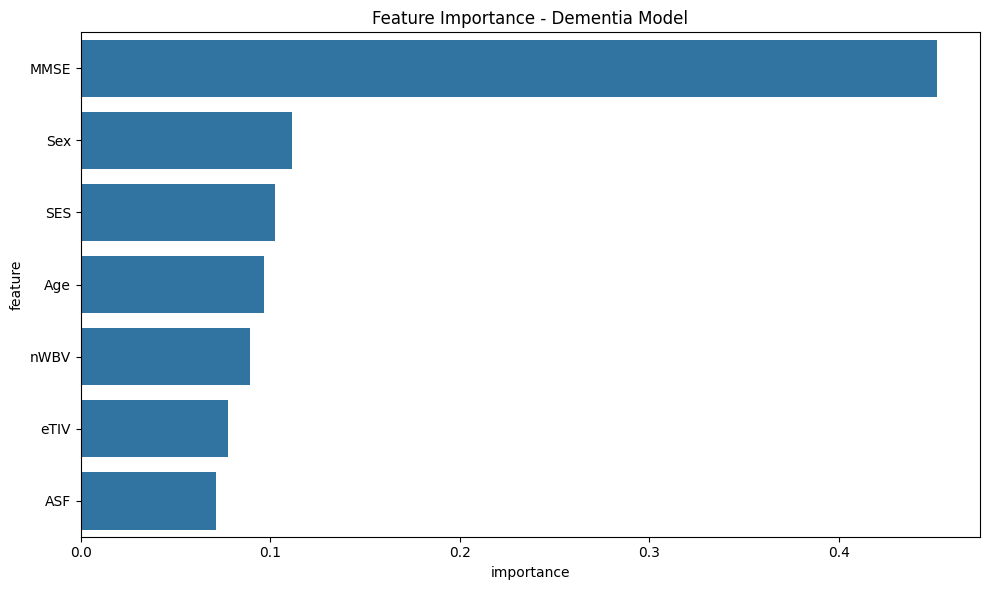


🎯 Training Progression Prediction Model...
Using base_score=0.5 for XGBoost progression model

📈 Progression Prediction Model:
Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        29

    accuracy                           1.00        29
   macro avg       1.00      1.00      1.00        29
weighted avg       1.00      1.00      1.00        29

✅ Progression model saved!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅✅✅ DEMENTIA & OASIS MODELS TRAINING COMPLETE! ✅✅✅

Models trained:
1. Dementia Classification (OASIS combined)
2. Progression Prediction Model


In [13]:
# ========================================
# STEP 1: SETUP
# ========================================
!pip install xgboost lightgbm scikit-learn pandas numpy matplotlib seaborn openpyxl -q

import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from google.colab import files

print("✅ Libraries installed!")

# ========================================
# STEP 2: UPLOAD DATASETS
# ========================================
print("Upload the following files:")
print("1. oasis_cross-sectional.xlsx")
print("2. oasis_longitudinal.csv")
print("3. oasis_longitudinal_demographics.xlsx")

uploaded = files.upload()

# ========================================
# STEP 3: LOAD OASIS CROSS-SECTIONAL
# ========================================
print("\n📊 Loading OASIS Cross-Sectional Data...")
oasis_cross = pd.read_excel('oasis_cross-sectional.xlsx')
print(f"OASIS Cross-Sectional: {oasis_cross.shape}")
print(oasis_cross.head())

# ========================================
# STEP 4: PREPROCESS CROSS-SECTIONAL
# ========================================
print("\n🔧 Preprocessing OASIS Cross-Sectional...")
if 'CDR' in oasis_cross.columns:
    oasis_cross['Target'] = (oasis_cross['CDR'] > 0).astype(int)
    if 'M/F' in oasis_cross.columns:
        oasis_cross['Sex'] = LabelEncoder().fit_transform(oasis_cross['M/F'])
    feature_cols = ['Age', 'Sex', 'Educ', 'SES', 'MMSE', 'eTIV', 'nWBV', 'ASF']
    available_features = [c for c in feature_cols if c in oasis_cross.columns]
    oasis_cross = oasis_cross.dropna(subset=['CDR'])
    X_cross = oasis_cross[available_features].fillna(oasis_cross[available_features].mean())
    y_cross = oasis_cross['Target']
    print(f"✅ OASIS Cross-Sectional: {X_cross.shape[0]} samples")
    print(f"Class distribution: {y_cross.value_counts()}")

# ========================================
# STEP 5: LOAD & PREPROCESS LONGITUDINAL
# ========================================
print("\n📊 Loading OASIS Longitudinal Data...")
oasis_long = pd.read_csv('oasis_longitudinal.csv')
print(f"OASIS Longitudinal: {oasis_long.shape}")
print(oasis_long.head())

print("\n🔧 Preprocessing OASIS Longitudinal...")
if 'Visit' in oasis_long.columns:
    oasis_long_bl = oasis_long[oasis_long['Visit'] == 1].copy()
else:
    oasis_long_bl = oasis_long.copy()
if 'Group' in oasis_long_bl.columns:
    oasis_long_bl['Target'] = oasis_long_bl['Group'].map({'Nondemented':0, 'Converted':1, 'Demented':1})
    if 'M/F' in oasis_long_bl.columns:
        oasis_long_bl['Sex'] = LabelEncoder().fit_transform(oasis_long_bl['M/F'])
    feature_cols_long = ['Age', 'Sex', 'EDUC', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF']
    available_features_long = [c for c in feature_cols_long if c in oasis_long_bl.columns]
    oasis_long_bl = oasis_long_bl.dropna(subset=['Target'])
    X_long = oasis_long_bl[available_features_long].fillna(oasis_long_bl[available_features_long].mean())
    y_long = oasis_long_bl['Target']
    print(f"✅ OASIS Longitudinal: {X_long.shape[0]} samples")
    print(f"Class distribution: {y_long.value_counts()}")

# ========================================
# STEP 6: COMBINE DATASETS
# ========================================
print("\n🔄 Combining datasets based on common features...")
common_features = list(set(X_cross.columns) & set(X_long.columns))
print(f"Common features: {common_features}")

X_combined = pd.concat([X_cross[common_features], X_long[common_features]], ignore_index=True)
y_combined = pd.concat([y_cross, y_long], ignore_index=True)
print(f"✅ Combined dataset samples: {X_combined.shape[0]}")

# ========================================
# STEP 7: TRAIN DEMENTIA CLASSIFIER
# ========================================
print("\n🎯 Training Dementia Classification Model...")
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.2, stratify=y_combined, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

dementia_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    random_state=42,
    eval_metric='logloss'
)
dementia_model.fit(X_train_scaled, y_train)

y_pred = dementia_model.predict(X_test_scaled)
y_pred_proba = dementia_model.predict_proba(X_test_scaled)[:, 1]

print("\n📈 Dementia Model Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
print(classification_report(y_test, y_pred, target_names=['Healthy','Demented']))

feature_importance = pd.DataFrame({
    'feature': common_features,
    'importance': dementia_model.feature_importances_
}).sort_values('importance', ascending=False)
print("\n🔝 Feature Importance:")
print(feature_importance)

plt.figure(figsize=(10,6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance - Dementia Model')
plt.tight_layout()
plt.savefig('feature_importance_dementia.png', dpi=150)
plt.show()

# ========================================
# STEP 8: TRAIN PROGRESSION PREDICTION MODEL
# ========================================
print("\n🎯 Training Progression Prediction Model...")

oasis_long_full = pd.read_csv('oasis_longitudinal.csv')
progression_data = []

for subject in oasis_long_full['Subject ID'].unique():
    subject_data = oasis_long_full[oasis_long_full['Subject ID'] == subject].sort_values('Visit')
    if len(subject_data) > 1:
        baseline = subject_data.iloc[0]
        final = subject_data.iloc[-1]
        if 'Group' in subject_data.columns:
            progressed = (baseline['Group'] == 'Nondemented') and (final['Group'] in ['Demented', 'Converted'])
            progression_data.append({
                'Age': baseline['Age'],
                'Sex': 1 if baseline['M/F']=='M' else 0,
                'EDUC': baseline.get('EDUC', np.nan),
                'SES': baseline.get('SES', np.nan),
                'MMSE_baseline': baseline.get('MMSE', np.nan),
                'CDR_baseline': baseline.get('CDR', np.nan),
                'eTIV': baseline.get('eTIV', np.nan),
                'nWBV_baseline': baseline.get('nWBV', np.nan),
                'Progressed': int(progressed)
            })

df_progression = pd.DataFrame(progression_data).dropna()

if len(df_progression) > 20:
    X_prog = df_progression.drop('Progressed', axis=1)
    y_prog = df_progression['Progressed'].astype(int)

    # Use stratified split to preserve positive label distribution
    X_train_prog, X_test_prog, y_train_prog, y_test_prog = train_test_split(
        X_prog, y_prog, test_size=0.2, random_state=42, stratify=y_prog
    )

    base_score_value = y_train_prog.mean()
    if base_score_value == 0 or base_score_value == 1:
        base_score_value = 0.5  # fallback if all zero or all one labels in train

    print(f"Using base_score={base_score_value} for XGBoost progression model")

    model_prog = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=4,
        random_state=42,
        objective='binary:logistic',
        base_score=base_score_value
    )
    model_prog.fit(X_train_prog, y_train_prog)
    y_pred_prog = model_prog.predict(X_test_prog)
    print("\n📈 Progression Prediction Model:")
    print(f"Accuracy: {accuracy_score(y_test_prog, y_pred_prog):.4f}")
    print(classification_report(y_test_prog, y_pred_prog))

    model_prog.save_model('dementia_progression_model.json')
    print("✅ Progression model saved!")
else:
    print("\n⏭️ Skipping Progression Prediction Model training: Not enough data points after preprocessing.")

# ========================================
# STEP 9: SAVE & DOWNLOAD
# ========================================
dementia_model.save_model('dementia_oasis_model.json')
joblib.dump(scaler, 'dementia_scaler.pkl')
files.download('dementia_oasis_model.json')
files.download('dementia_scaler.pkl')

if 'model_prog' in locals():
    model_prog.save_model('dementia_progression_model.json')
    files.download('dementia_progression_model.json')

files.download('feature_importance_dementia.png')

print("\n✅✅✅ DEMENTIA & OASIS MODELS TRAINING COMPLETE! ✅✅✅")
print("\nModels trained:")
print("1. Dementia Classification (OASIS combined)")
if 'model_prog' in locals():
    print("2. Progression Prediction Model")
else:
    print("2. Progression Prediction Model - Skipped")
